# Esure Assignment -- Geoff Chambers -- 03/02/2021
## 3. Modelling - preliminary reconnaissance

**Objective:** Quickly establish accuracy baselines for several "out-of-the-box" modelling algorithms
- Feature scaling
- Train vs test accuracy; bias vs variance
- Confusion matrices; balance of accuracy across classes
- Feature importance

---

In [1]:
### Environment: conda proj-home-ins

# Extensions & config
%load_ext autoreload
%autoreload 1

# General package imports
import os
import joblib
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

## LOAD CLEAN DATA FROM PREVIOUS NOTEBOOK

In [2]:
# Restore stored dataframe

%store -r policies_df

display(policies_df.head(3))
display(policies_df.info())

,claim3years,p1_emp_status,p1_pt_emp_status,bus_use,ad_buildings,risk_rated_area_b,sum_insured_buildings,ncd_granted_years_b,ad_contents,risk_rated_area_c,...,mta_fap,mta_aprp,last_ann_prem_gross,cover_start_y,cover_start_m,cover_start_d,quote_cover_days,cover_mta_days,p1_age_yrs,lapsed
police,,,,,,,,,,,,,,,,,,,,,
P000001,False,R,NaN,False,True,19.0,1000000.0,7.0,True,6.0,...,NaN,NaN,274.81,2007.0,11,22,0.0,NaN,68.438056,True
P000002,False,E,NaN,True,True,25.0,1000000.0,6.0,True,9.0,...,308.83,-9.27,308.83,2008.0,1,1,40.0,NaN,37.618070,False
P000003,False,E,NaN,False,False,NaN,0.0,0.0,True,12.0,...,52.65,52.65,52.65,2007.0,11,23,0.0,1076.0,60.454483,False


<class 'pandas.core.frame.DataFrame'>
Index: 189021 entries, P000001 to P256136
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   claim3years             189021 non-null  bool    
 1   p1_emp_status           189021 non-null  object  
 2   p1_pt_emp_status        1782 non-null    object  
 3   bus_use                 189021 non-null  bool    
 4   ad_buildings            189021 non-null  bool    
 5   risk_rated_area_b       140876 non-null  float64 
 6   sum_insured_buildings   189021 non-null  float64 
 7   ncd_granted_years_b     189021 non-null  float64 
 8   ad_contents             189021 non-null  bool    
 9   risk_rated_area_c       180290 non-null  float64 
 10  sum_insured_contents    189021 non-null  float64 
 11  ncd_granted_years_c     189021 non-null  float64 
 12  contents_cover          189021 non-null  bool    
 13  buildings_cover         189021 non-null  bool    
 14  sp

None

## FEATURE PREPARATION
- Encode categoricals
- Scaling

In [3]:
target_var = 'lapsed'

y = policies_df[target_var]
policies_df.drop(columns=[target_var], inplace=True)

In [4]:
# Split feature dataframe by type

num_df = policies_df.select_dtypes('number')
bool_df = policies_df.select_dtypes('bool').astype(int) # retain boolean features as integer 0/1
cat_df = policies_df.select_dtypes(exclude=['number', 'bool']).copy()

In [5]:
# For categoricals, separate features with nulls for separate (faster) processing

cat_cols_wnulls = cat_df.columns[cat_df.isnull().any()]
cat_df_wnulls = cat_df[cat_cols_wnulls]
cat_df.drop(columns=cat_cols_wnulls, inplace=True)

In [6]:
# One-hot encode clean categoricals

encoder = OneHotEncoder(dtype=int)
cat_enc = encoder.fit_transform(cat_df)
encoded_colnames = [f"{col}_{cat}" for col, categories in zip(cat_df.columns, encoder.categories_) for cat in categories]
cat_enc_df = pd.DataFrame(cat_enc.toarray(), index=cat_df.index, columns=encoded_colnames)

In [7]:
# One-hot encode categoricals with nulls - null values will be represented as all zero (i.e., no category enabled)

nullcat_enc_dfs = []
for col, ser in cat_df_wnulls.items():
    ser_clean = ser.dropna()
    encoder = OneHotEncoder(dtype=int)
    enc_array = encoder.fit_transform(ser_clean.to_frame())
    enc_df = pd.DataFrame(enc_array.toarray(), index=ser_clean.index,
                          columns=[f"{col}_{c}" for c in encoder.categories_[0]])
    enc_df = enc_df.reindex(index=ser.index, fill_value=0)
    nullcat_enc_dfs.append(enc_df)

In [8]:
# Recombine all encoded categoricals

cat_enc_df = pd.concat([cat_enc_df] + nullcat_enc_dfs, axis=1)
cat_enc_df

,p1_emp_status_A,p1_emp_status_C,p1_emp_status_E,p1_emp_status_F,p1_emp_status_H,p1_emp_status_I,p1_emp_status_N,p1_emp_status_R,p1_emp_status_S,p1_emp_status_U,...,cover_start_d_31,p1_pt_emp_status_C,p1_pt_emp_status_E,p1_pt_emp_status_F,p1_pt_emp_status_H,p1_pt_emp_status_I,p1_pt_emp_status_R,p1_pt_emp_status_S,p1_pt_emp_status_U,p1_pt_emp_status_V
police,,,,,,,,,,,,,,,,,,,,,
P000001,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
P000002,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P000003,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P000004,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
P000005,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P256132,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
P256133,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
P256134,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Scale numeric features, fill nulls with zero (in scaled data)

scaler = RobustScaler()
num_scale_data = scaler.fit_transform(num_df)
num_scale_df = pd.DataFrame(num_scale_data, index=num_df.index, columns=num_df.columns).fillna(0)
num_scale_df

,risk_rated_area_b,sum_insured_buildings,ncd_granted_years_b,risk_rated_area_c,sum_insured_contents,ncd_granted_years_c,spec_sum_insured,spec_item_prem,unspec_hrp_prem,bedrooms,...,paying_guests,yearbuilt,payment_frequency,mta_fap,mta_aprp,last_ann_prem_gross,cover_start_y,quote_cover_days,cover_mta_days,p1_age_yrs
police,,,,,,,,,,,,,,,,,,,,,
P000001,0.909091,0.0,0.333333,-0.1,0.0,1.0,7500.0,44.42,1.000000,0.0,...,0.0,0.35,0.0,0.000000,0.000000,0.873544,-0.2,-0.863636,0.000000,0.030674
P000002,1.454545,0.0,0.000000,0.2,0.0,1.0,0.0,0.00,1.975904,0.0,...,0.0,0.35,0.0,1.075064,-0.051269,1.178437,0.0,0.954545,0.000000,-2.087693
P000003,0.000000,-1000000.0,-2.000000,0.5,0.0,1.0,0.0,0.00,0.000000,-1.0,...,0.0,0.00,0.0,-1.222412,0.291186,-1.117494,-0.2,-0.863636,0.173541,-0.518065
P000004,0.000000,-1000000.0,-2.000000,0.7,0.0,1.0,0.0,0.00,0.000000,-1.0,...,0.0,-1.90,0.0,0.000000,0.000000,-1.103334,-0.2,0.000000,0.000000,0.961987
P000005,-0.363636,0.0,0.333333,0.3,0.0,1.0,0.0,0.00,1.591968,0.0,...,0.0,0.35,0.0,0.000000,0.000000,0.602617,-0.2,0.181818,0.000000,0.264584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P256132,0.636364,0.0,-1.333333,0.3,0.0,-4.0,0.0,0.00,1.530924,0.0,...,0.0,0.85,0.0,0.000000,0.000000,0.517476,-0.6,0.000000,0.000000,0.001882
P256133,-0.818182,0.0,-0.333333,-0.7,0.0,-1.0,0.0,0.00,2.151807,0.0,...,0.0,0.85,0.0,0.045424,1.073045,0.149489,-1.6,0.000000,1.469316,0.317087
P256134,-0.727273,0.0,-0.333333,1.1,0.0,-1.0,0.0,0.00,0.000000,0.0,...,0.0,-1.15,0.0,0.000000,0.000000,0.985481,-0.4,0.000000,0.000000,-0.500941


In [10]:
# Recombine all engineered features

features_df = pd.concat([num_scale_df, bool_df, cat_enc_df], axis=1)

display(features_df.head())
display(features_df.info())

,risk_rated_area_b,sum_insured_buildings,ncd_granted_years_b,risk_rated_area_c,sum_insured_contents,ncd_granted_years_c,spec_sum_insured,spec_item_prem,unspec_hrp_prem,bedrooms,...,cover_start_d_31,p1_pt_emp_status_C,p1_pt_emp_status_E,p1_pt_emp_status_F,p1_pt_emp_status_H,p1_pt_emp_status_I,p1_pt_emp_status_R,p1_pt_emp_status_S,p1_pt_emp_status_U,p1_pt_emp_status_V
police,,,,,,,,,,,,,,,,,,,,,
P000001,0.909091,0.0,0.333333,-0.1,0.0,1.0,7500.0,44.42,1.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
P000002,1.454545,0.0,0.000000,0.2,0.0,1.0,0.0,0.00,1.975904,0.0,...,0,0,0,0,0,0,0,0,0,0
P000003,0.000000,-1000000.0,-2.000000,0.5,0.0,1.0,0.0,0.00,0.000000,-1.0,...,0,0,0,0,0,0,0,0,0,0
P000004,0.000000,-1000000.0,-2.000000,0.7,0.0,1.0,0.0,0.00,0.000000,-1.0,...,0,0,0,0,0,0,0,0,0,0
P000005,-0.363636,0.0,0.333333,0.3,0.0,1.0,0.0,0.00,1.591968,0.0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 189021 entries, P000001 to P256136
Columns: 220 entries, risk_rated_area_b to p1_pt_emp_status_V
dtypes: float64(22), int32(198)
memory usage: 175.9+ MB


None

In [11]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(features_df, y, random_state=42)

In [12]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(141765, 220)
(47256, 220)
(141765,)
(47256,)


In [13]:
%store -r

## QUICKLOOK MODEL RECONNAISSANCE
- Train several models with (near) default hyperparameters
- Establish baselines for accuracy and training times

In [13]:
# Define models for reccy

classifiers = {
    'logistic_regression': LogisticRegression(),
    'logistic_regression_L1': LogisticRegression(penalty='l1', solver='saga'),
    'random_forest': RandomForestClassifier(),
    'neural_network_100': MLPClassifier(hidden_layer_sizes=(100,)),
    'neural_network_128-64': MLPClassifier(hidden_layer_sizes=(128, 64))
}

In [14]:
# Fit models 

training_time = {} # hold time to fit each classifier, in seconds
train_acc = {} # hold accuracy (F1-score) on training data
test_acc = {} # hold accuracy (F1-score) on test data

model_dir = "../models/"
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

for name, model in classifiers.items():
    
    # Fit model
    t1 = datetime.now()
    model.fit(X_train, y_train)
    t2 = datetime.now()
    
    # Store training time
    delta = t2 - t1
    training_time[name] = delta.seconds + delta.microseconds / 1e6
    
    # Store accuracy
    train_acc[name] = f1_score(y_train, model.predict(X_train))
    test_acc[name] = f1_score(y_test, model.predict(X_test))
    
    # Save model file
    model_file = model_dir + f"reccy_{name}.joblib"
    joblib.dump(model, model_file)
    
    # Report progress
    print(f"{name}: {model}")
    print(f"  Training Time: {training_time[name]:.3f} seconds")
    print(f"    Training F1: {train_acc[name]:.3f}")
    print(f"   Test data F1: {test_acc[name]:.3f}")
    print("-------------------------------------------------------------------\n")

logistic_regression: LogisticRegression()
  Training Time: 3.529 seconds
    Training F1: 0.008
   Test data F1: 0.008
-------------------------------------------------------------------



C:\ProgramData\Anaconda3\envs\proj-home-ins\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


logistic_regression_L1: LogisticRegression(penalty='l1', solver='saga')
  Training Time: 98.530 seconds
    Training F1: 0.014
   Test data F1: 0.016
-------------------------------------------------------------------

random_forest: RandomForestClassifier()
  Training Time: 89.652 seconds
    Training F1: 1.000
   Test data F1: 0.411
-------------------------------------------------------------------

neural_network_100: MLPClassifier()
  Training Time: 83.274 seconds
    Training F1: 0.401
   Test data F1: 0.393
-------------------------------------------------------------------



C:\ProgramData\Anaconda3\envs\proj-home-ins\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


neural_network_128-64: MLPClassifier(hidden_layer_sizes=(128, 64))
  Training Time: 863.935 seconds
    Training F1: 0.674
   Test data F1: 0.418
-------------------------------------------------------------------



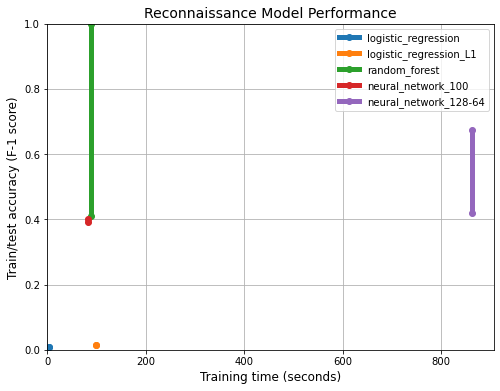

In [14]:
# Plot accuracy vs training time

fig, ax = plt.subplots(figsize=(8, 6))

for name in classifiers.keys():
    time = training_time[name]
    acc_trn = train_acc[name]
    acc_tst = test_acc[name]
    
    ax.plot([time, time], [acc_trn, acc_tst], marker='o', linewidth=5, label=name)

ax.legend()
ax.grid()
ax.set_xlim(left=0)
ax.set_ylim(0, 1)
ax.set_xlabel("Training time (seconds)", fontsize=12)
ax.set_ylabel("Train/test accuracy (F-1 score)", fontsize=12)
ax.set_title("Reconnaissance Model Performance", fontsize=14)
fig.savefig("../images/model_reccy_summary.png")
plt.show()

## MODEL EVALUATION
Model 'random_forest' selected from above reconnaissance
- Accuracy across classes
- Bias vs variance

In [15]:
name = 'random_forest'
model = classifiers[name]

In [16]:
y_act = y_test
y_pred = model.predict(X_test)

target_names = ['Unlapsed', 'Lapsed']

In [17]:
# Accuracy measures by class

print(classification_report(y_act, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Unlapsed       0.78      0.95      0.86     34158
      Lapsed       0.70      0.29      0.41     13098

    accuracy                           0.77     47256
   macro avg       0.74      0.62      0.63     47256
weighted avg       0.76      0.77      0.73     47256



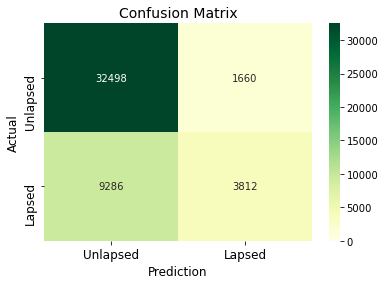

In [18]:
# Plot confusion matrix

cm = confusion_matrix(y_act, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='YlGn', vmin=0, xticklabels=target_names, yticklabels=target_names)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Prediction", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Confusion Matrix", fontsize=14)
plt.savefig(f"../images/conf-matrix_reccy_{name}.png")
plt.show()

***Comments on accuracy:***
- Low test accuracy, model seems overfit (see next)
- Prediction accuracy is significantly worse on lapsed policies than unlapsed, i.e., much more likely to miss lapses than incorrectly predict a lapse (biased towards false negatives)

***Considered conducting accuracy vs data volume experiment to analyse bias/variance, but it seems relatively clear from the reccy results above, and intuitively, that the model is overfitting*** 

Ideas to try:
- Reduce dimensionality
    - Firstly, with a bit of knowledge of the meaning of undersampled categories, might be able to combine into higher-level categories in a sensible way.
    - Evaluate parameters of L1 logistic regression to identify features which did not contribute, and eliminate them.
    - Automated dimensionality reduction, i.e., PCA.
- Tweak hyperparameters
    - Reduce network size (for case of neural network)
    - Reduce max tree depth (for case of RF)

## FEATURE IMPORTANCE

### *Coefficients from logistic regression with L1 regularisation*
Bearing in mind how poor this model is ...

In [19]:
# Extract coefficients from model as importance Series

model = classifiers['logistic_regression_L1']
importance_logreg = np.abs(model.coef_[0]) # coefficients are (1,n) for binary classification
importance_logreg = pd.Series(importance_logreg, index=features_df.columns)
importance_logreg.sort_values(ascending=False, inplace=True)

importance_logreg.head()

spec_sum_insured        0.000065
sum_insured_contents    0.000015
occ_status_PH           0.000004
roof_construction_11    0.000004
wall_construction_15    0.000004
dtype: float64

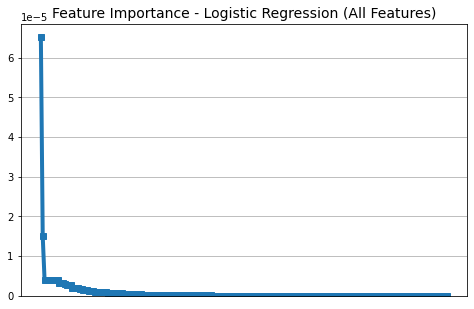

In [20]:
# General shape of importance curve
# - importance concentrated in small number of features

fig, ax = plt.subplots(figsize=(8, 5))
importance_logreg.plot(ax=ax, marker='s', linewidth=4)
ax.set_xticks([])
ax.set_ylim(bottom=0)
ax.grid()
ax.set_title("Feature Importance - Logistic Regression (All Features)", fontsize=14)
fig.savefig("../images/feat-import_logreg_all.png")
plt.show()

In [21]:
# Features with nil importance - candidates for dimensionality reduction

zeros = importance_logreg == 0
print(f"{zeros.sum()} features with zero importance in L1 regularised logistic regression:")
display(sorted(importance_logreg.index[zeros]))

37 features with zero importance in L1 regularised logistic regression:


['cover_start_m_10',
 'cover_start_m_6',
 'cover_start_m_8',
 'cover_start_m_9',
 'occ_status_WD',
 'ownership_type_13',
 'ownership_type_15',
 'ownership_type_16',
 'ownership_type_6',
 'p1_mar_status_N',
 'p1_pt_emp_status_C',
 'p1_pt_emp_status_F',
 'p1_pt_emp_status_H',
 'p1_pt_emp_status_I',
 'p1_pt_emp_status_U',
 'payment_frequency',
 'prop_type_20',
 'prop_type_23',
 'prop_type_27',
 'prop_type_28',
 'prop_type_30',
 'prop_type_8',
 'roof_construction_12',
 'roof_construction_14',
 'roof_construction_16',
 'roof_construction_18',
 'roof_construction_6',
 'roof_construction_8',
 'roof_construction_9',
 'roof_construction_99',
 'wall_construction_1',
 'wall_construction_12',
 'wall_construction_20',
 'wall_construction_21',
 'wall_construction_22',
 'wall_construction_6',
 'wall_construction_9']

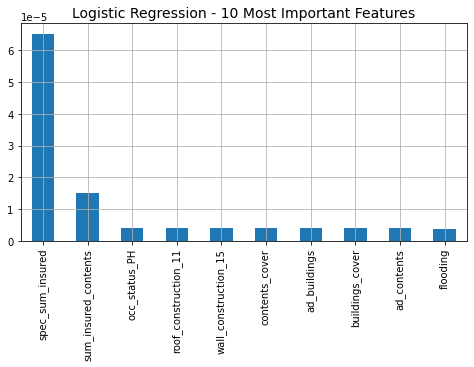

In [22]:
# Detailed plot of most important features

fig, ax = plt.subplots(figsize=(8, 4))
importance_logreg.iloc[:10].plot(ax=ax, kind='bar')
ax.set_ylim(bottom=0)
ax.grid()
ax.set_title("Logistic Regression - 10 Most Important Features", fontsize=14)
fig.savefig("../images/feat-import_logreg_top10.png")
plt.show()

**Not particularly convinced by this, given how poorly the model performs. Neither of the two main features seemed particularly relevant in the exploratory analysis** 

### *Random forest feature importance*

In [23]:
# Extract feature importance from random forest model

model = classifiers['random_forest']

importance = model.feature_importances_

# Standard deviation of importance for each feature, over ensemble of trees
std_importance = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

importance_rf = pd.DataFrame({'importance': importance, 'std_import': std_importance}, index=features_df.columns)
importance_rf.sort_values('importance', ascending=False, inplace=True)

display(importance_rf.head())

,importance,std_import
last_ann_prem_gross,0.066178,0.003791
p1_age_yrs,0.064522,0.001932
risk_rated_area_c,0.057369,0.003332
risk_rated_area_b,0.046565,0.003106
cover_start_y,0.039983,0.003563


In [24]:
importance_rf['lo_bound'] = importance_rf.importance - importance_rf.std_import
importance_rf['hi_bound'] = importance_rf.importance + importance_rf.std_import

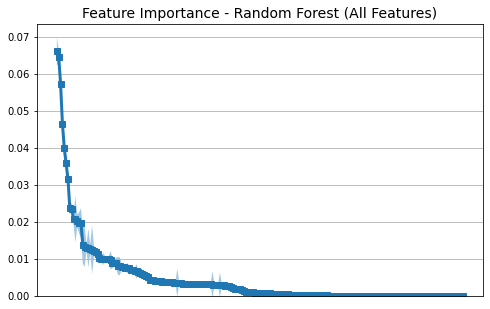

In [25]:
# General shape of importance curve
# - importance spread over more features than logistic regression, but still fairly concentrated

fig, ax = plt.subplots(figsize=(8, 5))
importance_rf.importance.plot(ax=ax, marker='s', linewidth=3)
ax.fill_between(importance_rf.index, importance_rf.lo_bound, importance_rf.hi_bound, alpha=0.4)
ax.set_xticks([])
ax.set_ylim(bottom=0)
ax.grid()
ax.set_title("Feature Importance - Random Forest (All Features)", fontsize=14)
fig.savefig("../images/feat-import_rf_all.png")
plt.show()

In [26]:
# Features with nil importance - candidates for dimensionality reduction

zeros = importance_rf.importance < importance_rf.importance[0] / 1e3
print(f"{zeros.sum()} features with negligible importance in random forest:")
display(sorted(importance_rf.index[zeros]))

68 features with negligible importance in random forest:


['cover_start_m_10',
 'cover_start_m_6',
 'cover_start_m_8',
 'cover_start_m_9',
 'hp1_addon_pre_ren',
 'hp3_addon_pre_ren',
 'occ_status_OT',
 'occ_status_WD',
 'occ_status_WE',
 'ownership_type_1',
 'ownership_type_15',
 'ownership_type_16',
 'ownership_type_17',
 'ownership_type_6',
 'p1_emp_status_A',
 'p1_emp_status_C',
 'p1_emp_status_F',
 'p1_emp_status_I',
 'p1_mar_status_B',
 'p1_mar_status_N',
 'p1_pt_emp_status_C',
 'p1_pt_emp_status_F',
 'p1_pt_emp_status_H',
 'p1_pt_emp_status_I',
 'p1_pt_emp_status_R',
 'p1_pt_emp_status_U',
 'payment_frequency',
 'prop_type_20',
 'prop_type_21',
 'prop_type_23',
 'prop_type_24',
 'prop_type_27',
 'prop_type_28',
 'prop_type_29',
 'prop_type_3',
 'prop_type_30',
 'prop_type_37',
 'prop_type_38',
 'prop_type_39',
 'prop_type_44',
 'prop_type_8',
 'roof_construction_10',
 'roof_construction_12',
 'roof_construction_14',
 'roof_construction_15',
 'roof_construction_16',
 'roof_construction_18',
 'roof_construction_3',
 'roof_construction_5',

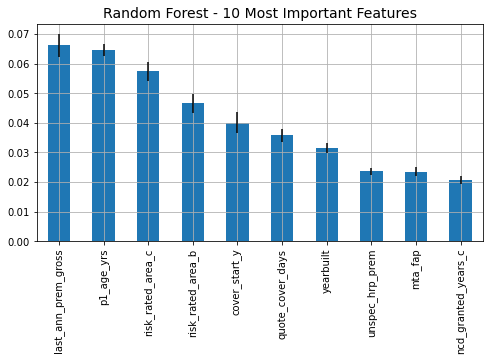

In [27]:
# Detailed plot of most important features

fig, ax = plt.subplots(figsize=(8, 4))
most_important = importance_rf.iloc[:10]
most_important.importance.plot(ax=ax, kind='bar', yerr=most_important.std_import)
ax.set_ylim(bottom=0)
ax.grid()
ax.set_title("Random Forest - 10 Most Important Features", fontsize=14)
fig.savefig("../images/feat-import_rf_top10.png")
plt.show()

**Several features identified here seem a bit more plausible, and consistent with observations from EDA**
- last_ann_prem_gross, cover_start_y
- This perhaps is not giving due credit to categorical features, for instance from EDA marital status and payment method seemed important

**Similar features seem negligible in both approaches:**
- Some categories of ownership type, property type, roof/wall construction (although they may be undersampled ones, would have to check the *most* important categories of these)
- Month of coverage start

## OLD / BACKUP CELLS

In [ ]:
raise RuntimeError('Stop here, dont run old cells')